<a href="https://colab.research.google.com/github/Jarin160/DVD-Rental-Duration-Prediction/blob/main/dvd_rental_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [11]:
data = pd.read_csv('rental_info.csv')
data.head(5)

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [12]:
data.shape

(15861, 15)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [14]:
data["special_features"].value_counts()

,count
special_features,
"{Trailers,Commentaries,""Behind the Scenes""}",1308
{Trailers},1139
"{Trailers,Commentaries}",1129
"{Trailers,""Behind the Scenes""}",1122
"{""Behind the Scenes""}",1108
"{Commentaries,""Deleted Scenes"",""Behind the Scenes""}",1101
{Commentaries},1089
"{Commentaries,""Behind the Scenes""}",1078
"{Trailers,""Deleted Scenes""}",1047


In [63]:
data['rental_length'] = pd.to_datetime(data['return_date']) - pd.to_datetime(data['rental_date'])
data["rental_length_days"] = data['rental_length'].dt.total_seconds() / (24 * 60 * 60)

data["deleted_scenes"] =  np.where(data["special_features"].str.contains("Deleted Scenes"), 1,0)
data["behind_the_scenes"] = np.where(data["special_features"].str.contains("Behind the Scenes"), 1,0)
data["trailers"] = np.where(data["special_features"].str.contains("Trailers"), 1,0)


In [64]:
processed_data = data.drop(columns=['rental_date', 'return_date','special_features','rental_length'])
processed_data.head()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes,trailers
0,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3.865278,0,1,1
1,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2.836806,0,1,1
2,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7.238889,0,1,1
3,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2.100000,0,1,1
4,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4.045139,0,1,1


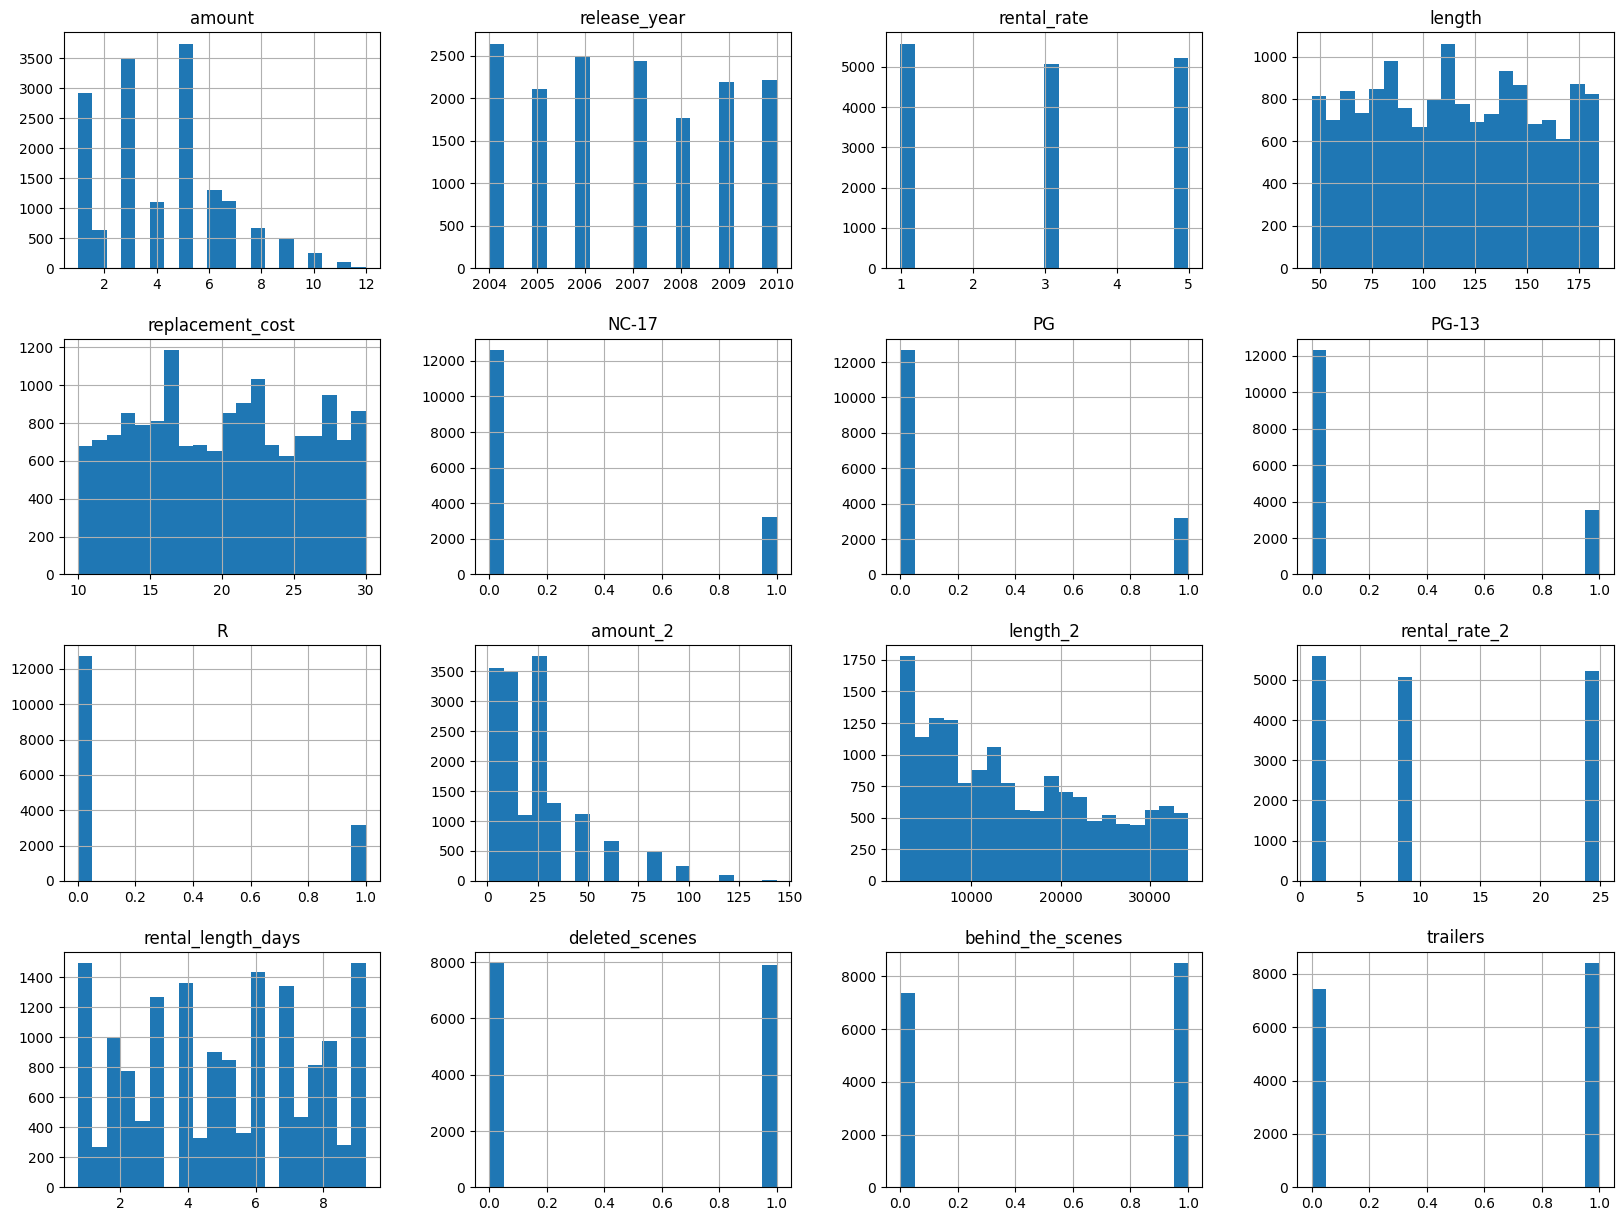

In [65]:
processed_data.hist(bins=20, figsize=(20, 15))
plt.show()

In [66]:
X= processed_data.drop(columns=["rental_length_days"])
y= processed_data["rental_length_days"]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [67]:
#Performing feature selection

lasso = Lasso(alpha=0.1, random_state=9)
lasso.fit(X_train, y_train)
lasso_coef = lasso.coef_
feature_importance = pd.Series(lasso_coef, index=X_train.columns)

print("All coefficients:")
print(feature_importance)

selected_features = feature_importance[feature_importance != 0]
print("\nSelected features (non-zero coefficients):")
print(selected_features)

X_train_lasso = X_train[selected_features.index]
X_test_lasso  = X_test[selected_features.index]
print("\nTraining data after Lasso feature selection:")
print(X_train_lasso.head())

All coefficients:
amount               1.093322
release_year         0.000000
rental_rate         -0.000000
length               0.000000
replacement_cost    -0.000000
NC-17                0.000000
PG                   0.000000
PG-13                0.000000
R                   -0.000000
amount_2             0.000778
length_2             0.000004
rental_rate_2       -0.176509
deleted_scenes      -0.000000
behind_the_scenes    0.000000
trailers            -0.000000
dtype: float64

Selected features (non-zero coefficients):
amount           1.093322
amount_2         0.000778
length_2         0.000004
rental_rate_2   -0.176509
dtype: float64

Training data after Lasso feature selection:
       amount  amount_2  length_2  rental_rate_2
6682     2.99    8.9401    8100.0         8.9401
8908     4.99   24.9001    2809.0         0.9801
11827    6.99   48.8601   29241.0        24.9001
6153     2.99    8.9401    5329.0         8.9401
10713    5.99   35.8801   14884.0         0.9801


In [73]:
def train_model(model, X_train, y_train, X_test, y_test, model_name):
  pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", model)
        ])
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  r2 = r2_score(y_test, y_pred)
  mse= mean_squared_error(y_test, y_pred)

  score_data = pd.DataFrame({
      "MSE": [mse],
      "R²": [r2]
  }, index=[model_name])

  return score_data

In [74]:
#Linear Regression

linear = LinearRegression()
model = linear

result1=train_model(model,X_train, y_train, X_test, y_test, model_name = 'Linear Regression (All Features)')
result2=train_model(model,X_train_lasso, y_train, X_test_lasso, y_test, model_name = 'Linear Regression (Lasso-Selected Features)')

results = pd.concat([result1, result2])
display(results)

,MSE,R²
Linear Regression (All Features),2.723920,0.600298
Linear Regression (Lasso-Selected Features),2.882203,0.577072


In [75]:
#Decision Tree
tree = DecisionTreeRegressor()
model = tree

result1=train_model(model,X_train, y_train, X_test, y_test, model_name = 'Decision Tree (All Features)')
result2=train_model(model,X_train_lasso, y_train, X_test_lasso, y_test, model_name = 'Decision Tree (Lasso-Selected Features)')

results = pd.concat([result1, result2])
display(results)

,MSE,R²
Decision Tree (All Features),1.932467,0.716434
Decision Tree (Lasso-Selected Features),2.175353,0.680794


In [90]:
#Random Forest
rf_param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search on All Features
rf_grid_all = GridSearchCV(
    RandomForestRegressor(random_state=9),
    rf_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid_all.fit(X_train, y_train)
forest_all = rf_grid_all.best_estimator_

# Grid Search on Lasso-Selected Features
rf_grid_lasso = GridSearchCV(
    RandomForestRegressor(random_state=9),
    rf_param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid_lasso.fit(X_train_lasso, y_train)
forest_lasso = rf_grid_lasso.best_estimator_

result1 = train_model(forest_all, X_train, y_train, X_test, y_test,
                      model_name='Random Forest (All Features)')
result2 = train_model(forest_lasso, X_train_lasso, y_train, X_test_lasso, y_test,
                      model_name='Random Forest (Lasso-Selected Features)')

results = pd.concat([result1, result2])
display(results)

,MSE,R²
Random Forest (All Features),1.821321,0.732744
Random Forest (Lasso-Selected Features),2.133070,0.686998


In [91]:
lin_scores = cross_val_score(linear, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

tree_scores = cross_val_score(tree, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

random_scores = cross_val_score(forest_all, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

def display_scores(model, scores):
    mse = -scores
    print(f"MSE for {model}: {mse.mean():.4f}")

display_scores("Linear Regression", lin_scores)
display_scores("Decision Tree", tree_scores)
display_scores("Random Forest", random_scores)



MSE for Linear Regression: 2.6703
MSE for Decision Tree: 1.9592
MSE for Random Forest: 1.8153


In [89]:
#XGBoost

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = xgb.DMatrix(data=X_train_scaled, label =y_train)
dtest = xgb.DMatrix(data=X_test_scaled, label =y_test)

params = {'objective':"reg:squarederror",
         'max_depth': 7,
          'learning_rate': 0.1
        }
cv_result = xgb.cv(params=params,
                    dtrain=dtrain,
                    num_boost_round=200,
                    nfold=10,
                    metrics='rmse',
                    as_pandas=True,
                    seed=9)

print("CV RMSE (best round):", cv_result['test-rmse-mean'].min())

best_num_round = cv_result['test-rmse-mean'].idxmin()

model = xgb.train(params=params,
                dtrain=dtrain,
                num_boost_round=best_num_round)
y_pred = model.predict(dtest)
mse= mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

score_data = pd.DataFrame([[mse, r2]],
                        columns=["MSE", "R2"])
score_data.index = ["XGBoost"]
display(score_data)

CV RMSE (best round): 1.2961792949879014


,MSE,R2
XGBoost,1.696292,0.75109
